In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["TF_NUM_INTRAOP_THREADS"] = "8" 
os.environ["TF_NUM_INTEROP_THREADS"] = "2"
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(2)
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Add, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

2025-04-20 17:51:10.222243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 17:51:11.432930: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 17:51:11.434654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-20 17:51:19.809851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("age_gender.csv")
df = df.drop("img_name", axis = 1)
print(df.head())
df.info()
df.isnull().sum()


   age  ethnicity  gender                                             pixels
0    1          2       0  129 128 128 126 127 130 133 135 139 142 145 14...
1    1          2       0  164 74 111 168 169 171 175 182 184 188 193 199...
2    1          2       0  67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3    1          2       0  193 197 198 200 199 200 202 203 204 205 208 21...
4    1          2       0  202 205 209 210 209 209 210 211 212 214 218 21...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   pixels     23705 non-null  object
dtypes: int64(3), object(1)
memory usage: 740.9+ KB


age          0
ethnicity    0
gender       0
pixels       0
dtype: int64

In [3]:
X=df['pixels']
y=df.drop("pixels", axis=1)
X = X.apply(lambda x: np.array(list(map(int, x.split(' '))), dtype=np.int32))
X = np.stack(X, axis=0)
X = X.reshape(-1, 48, 48, 1)
print("X shape:", X.shape)

X shape: (23705, 48, 48, 1)


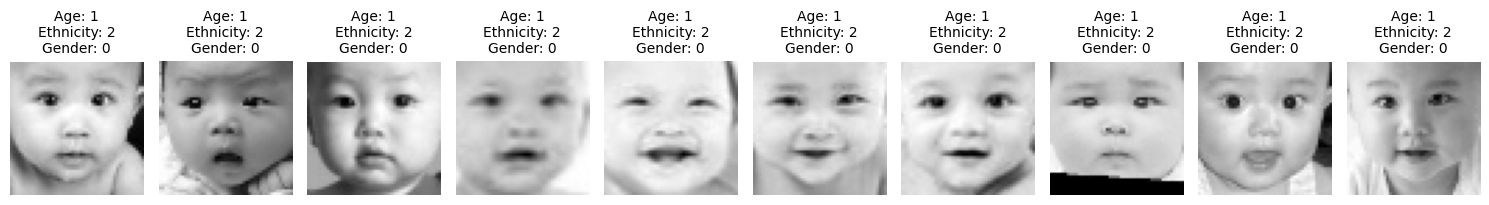

In [4]:
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i].squeeze(), cmap='gray')
    ax.axis("off")
    ax.set_title(
        f"Age: {y['age'].iloc[i]}\nEthnicity: {y['ethnicity'].iloc[i]}\nGender: {y['gender'].iloc[i]}",
        fontsize=10
    )
plt.tight_layout()
plt.show()

In [5]:
X = X / 255.0
ethnicity_matrix = np.array(y["ethnicity"])
num_classes = 5  # update if needed based on your dataset
ethnicity = to_categorical(ethnicity_matrix, num_classes=num_classes)

In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, ethnicity, test_size=0.2, random_state=42, stratify=ethnicity_matrix
)


In [7]:
def ConvFunc(x, filters=32, kernel_size=(3, 3), dropout_rate=0.1):
    x = Conv2D(filters, kernel_size=kernel_size, padding="same",
               kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(dropout_rate)(x)  # light dropout after conv block
    return x

def create_ethnicity_model():
    inputs = Input(shape=(48, 48, 1))

    x = ConvFunc(inputs, 32, dropout_rate=0.1)
    x = ConvFunc(x, 64, dropout_rate=0.15)
    x = ConvFunc(x, 128, dropout_rate=0.2)


    x = Flatten()(x)
    x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


ethnicity_model = create_ethnicity_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", patience=5, verbose=1, factor=0.5, min_lr=1e-5
)


2025-04-20 17:51:39.409387: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
ethnicity_model.fit(
    X_train, y_train, 
    batch_size=128,
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


In [ ]:
ethnicity_model.save_weights("ethnicity_weights.h5")


In [ ]:
ethnicity_model.evaluate(X_test, y_test)


In [8]:
df['age'].max()
age=df['age']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, age, test_size=0.2, random_state=42
)

In [10]:
y_train = np.array(y_train).astype("float32")  
y_test = np.array(y_test).astype("float32")
y_train = y_train / 116
y_test = y_test / 116


In [11]:
print("Max y_train:", y_train.max())  
print("Min y_train:", y_train.min())  

Max y_train: 1.0
Min y_train: 0.00862069


In [12]:
def ConvFunc(x, filters=32, kernel_size=(3, 3), dropout_rate=0.1):
    x = Conv2D(filters, kernel_size=kernel_size, padding="same",
               kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(dropout_rate)(x)
    return x

def create_deep_age_model():
    inputs = Input(shape=(48, 48, 1))

    # Add a 4th Conv block
    x = ConvFunc(inputs, 32, dropout_rate=0.1)
    x = ConvFunc(x, 64, dropout_rate=0.15)
    x = ConvFunc(x, 128, dropout_rate=0.2)
    x = ConvFunc(x, 256, dropout_rate=0.25)  # new deeper layer

    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)

    outputs = Dense(1, activation="softplus")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
        loss=tf.keras.losses.Huber(delta=2.0),
        metrics=["mae"]
    )

    return model
age_model = create_deep_age_model()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=5, verbose=1, factor=0.5, min_lr=1e-5
)


In [ ]:
age_model.fit(
    X_train, y_train,
    batch_size=128,
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

In [ ]:
age_model.save_weights("age_weights.h5")


In [ ]:
age_model.evaluate(X_test, y_test)


In [13]:
gender=df['gender']
print(gender)

0        0
1        0
2        0
3        0
4        0
        ..
23700    1
23701    1
23702    1
23703    1
23704    1
Name: gender, Length: 23705, dtype: int64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, gender, test_size=0.2, random_state=42
)

In [15]:
def ConvFunc(x, filters=32, kernel_size=(3, 3), dropout_rate=0.1):
    x = Conv2D(filters, kernel_size=kernel_size, padding="same",
               kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(dropout_rate)(x)
    return x
def create_gender_model():
    inputs = Input(shape=(48, 48, 1))

    x = ConvFunc(inputs, 32, dropout_rate=0.1)
    x = ConvFunc(x, 64, dropout_rate=0.15)
    x = ConvFunc(x, 128, dropout_rate=0.2)


    x = Flatten()(x)
    x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


gender_model = create_gender_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", patience=5, verbose=1, factor=0.5, min_lr=1e-5
)

In [ ]:
gender_model.fit(
    X_train, y_train, 
    batch_size=128,
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


In [ ]:
gender_model.save_weights('gender_weights.h5')

In [16]:
from PIL import Image
import numpy as np
import cv2

def preprocess_image(image_path):
    img = Image.open(image_path).convert("L")  # Grayscale
    img = img.resize((48, 48))                 # Resize
    img = np.array(img).astype("float32") / 255.0
    img = img.reshape(1, 48, 48, 1)             # Add batch + channel dims
    return img

In [17]:
from tensorflow.keras.models import load_model

ethnicity_model = create_ethnicity_model() 
ethnicity_model.load_weights("ethnicity_weights.h5")
age_model=create_deep_age_model()
age_model.load_weights("age_weights.h5")
gender_model = create_gender_model()
gender_model.load_weights("gender_weights.h5")

In [18]:
def predict_all(image_path):
    img = preprocess_image(image_path)

    predicted_age = age_model.predict(img)[0][0]
    predicted_age = predicted_age * 116
    predicted_gender_prob = gender_model.predict(img)[0][0]
    gender_label = "Female" if predicted_gender_prob > 0.5 else "Male"
    predicted_ethnicity = np.argmax(ethnicity_model.predict(img), axis=1)[0]
    ethnicity_labels = ["White", "Black", "Asian", "Indian", "Other"]
    ethnicity_label = ethnicity_labels[predicted_ethnicity]

    return predicted_age, gender_label, ethnicity_label


In [19]:
age, gender, ethnicity = predict_all("testimage1.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 74ms/step
Predicted Age: 40.8 years
Predicted Gender: Male
Predicted Ethnicity: Black


In [20]:
age, gender, ethnicity = predict_all("testimage2.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 14ms/step
Predicted Age: 45.8 years
Predicted Gender: Male
Predicted Ethnicity: Black


In [21]:
age, gender, ethnicity = predict_all("testimage3.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 13ms/step
Predicted Age: 62.5 years
Predicted Gender: Male
Predicted Ethnicity: Black


In [22]:
age, gender, ethnicity = predict_all("testimage4.jpg")
print(f"Predicted Age: {age:.1f} years")
print(f"Predicted Gender: {gender}")
print(f"Predicted Ethnicity: {ethnicity}")

1/1 [==============================] - 0s 13ms/step
Predicted Age: 50.1 years
Predicted Gender: Female
Predicted Ethnicity: Black
